In [ ]:
!pip install transformers[torch] accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 30.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylin

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import logging

In [ ]:
# Mengatur logging transformers
logging.set_verbosity_error()

# Membaca data ulasan dari Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path ke file ulasan di Google Drive
file_path = '/content/drive/MyDrive/Colab Notebooks/pospay_fullset.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Membuat kolom 'sentiment' berdasarkan nilai 'score'
def map_score_to_sentiment(score):
    if score <= 2:
        return 0  # Negatif
    elif score == 3:
        return 1  # Netral
    else:
        return 2  # Positif
df['sentiment'] = df['score'].apply(map_score_to_sentiment)

In [ ]:
# Memeriksa kolom dalam data
print("Kolom dalam dataset:", df.columns)

Kolom dalam dataset: Index(['userName', 'content', 'score', 'at', 'sentiment'], dtype='object')


In [ ]:
df.head()

,userName,content,score,at,sentiment
0,jermias rahaningmas,Sangat mudah di gunakan. Kekurangannya belum a...,5,10/8/2023 0:14,2
1,Nicolaus Cipto Cahyono,Saya pikir saya mengerti bagaimana caranya bay...,5,8/17/2023 5:43,2
2,Satria Buana Edriza,Lebih di tingkatkan lagi dalam pengaplikasian ...,5,12/12/2023 4:29,2
3,Yulia,"Pospay keren euyyy,, utk nabung bisa banget,, ...",5,12/12/2023 9:14,2
4,M chabib Asari,"Tak ganti ke 1, karena sekarang kuatasnya turu...",5,10/3/2023 10:06,2


In [ ]:
# Pastikan kolom 'content' dan 'sentiment' ada dalam dataset
if 'content' not in df.columns or 'sentiment' not in df.columns:
    raise KeyError("Kolom 'content' atau 'sentiment' tidak ditemukan dalam dataset. Kolom yang tersedia: " + str(df.columns))

In [ ]:
# Pra-pemrosesan data
def preprocess_text(text):
    text = text.lower()  # Case folding
    text = re.sub(r'\d+', '', text)  # Menghilangkan angka
    text = re.sub(r'\s+', ' ', text).strip()  # Menghilangkan spasi berlebih
    text = re.sub(r'[^\w\s]', '', text)  # Menghilangkan simbol
    return text

df['cleaned_review'] = df['content'].apply(preprocess_text)

In [ ]:
from torch.utils.data import Dataset, DataLoader

# Buat custom dataset
class MyDataset(Dataset):
    def __init__(self, tokenizer, df, max_length):
        self.tokenizer = tokenizer
        self.data = df
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        review = self.data.iloc[idx]['cleaned_review']
        label = self.data.iloc[idx]['sentiment']

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# Membagi data menjadi data pelatihan dan data validasi
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
# Inisialisasi tokenizer dan dataset
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = MyDataset(tokenizer, train_df, max_length=128)
val_dataset = MyDataset(tokenizer, val_df, max_length=128)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Inisialisasi trainer dengan dataset
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

In [ ]:
# Training
trainer.train()

{'loss': 1.1218, 'grad_norm': 9.665481567382812, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.0029832935560859188}
{'loss': 1.0579, 'grad_norm': 7.481124401092529, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.0059665871121718375}
{'loss': 1.0638, 'grad_norm': 8.705625534057617, 'learning_rate': 3e-06, 'epoch': 0.008949880668257757}
{'loss': 0.9917, 'grad_norm': 4.340079307556152, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.011933174224343675}
{'loss': 1.0175, 'grad_norm': 7.556874752044678, 'learning_rate': 5e-06, 'epoch': 0.014916467780429593}
{'loss': 1.0111, 'grad_norm': 5.611662864685059, 'learning_rate': 6e-06, 'epoch': 0.017899761336515514}
{'loss': 0.9269, 'grad_norm': 5.995715618133545, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.020883054892601432}
{'loss': 0.8678, 'grad_norm': 9.56803035736084, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.02386634844868735}
{'loss': 0.8227, 'grad_norm': 9.051194190979004, 'learning_rate': 9e-06, 'epoch': 0.02

TrainOutput(global_step=3352, training_loss=0.530804821247844, metrics={'train_runtime': 466.7382, 'train_samples_per_second': 28.725, 'train_steps_per_second': 7.182, 'train_loss': 0.530804821247844, 'epoch': 1.0})

In [ ]:
# Evaluasi model
eval_result = trainer.evaluate()
print(f"Eval result: {eval_result}")

{'eval_loss': 0.49683788418769836, 'eval_runtime': 24.968, 'eval_samples_per_second': 134.252, 'eval_steps_per_second': 16.781, 'epoch': 1.0}
Eval result: {'eval_loss': 0.49683788418769836, 'eval_runtime': 24.968, 'eval_samples_per_second': 134.252, 'eval_steps_per_second': 16.781, 'epoch': 1.0}


In [ ]:
# Prediksi
preds_output = trainer.predict(val_dataset)
preds_logits = preds_output.predictions
preds_labels = np.argmax(preds_logits, axis=1)

In [ ]:
# Menghitung probabilitas dengan softmax
from torch.nn.functional import softmax  # Import softmax dari torch.nn.functional

preds_probs = softmax(torch.tensor(preds_logits), dim=-1).numpy()
preds_confidence = np.max(preds_probs, axis=1)

In [ ]:
# Evaluasi hasil prediksi
true_labels = val_df['sentiment'].values
print(classification_report(true_labels, preds_labels, target_names=['Negative', 'Neutral', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.82      0.92      0.87      1222
     Neutral       0.00      0.00      0.00       134
    Positive       0.93      0.93      0.93      1996

    accuracy                           0.89      3352
   macro avg       0.58      0.62      0.60      3352
weighted avg       0.86      0.89      0.87      3352



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


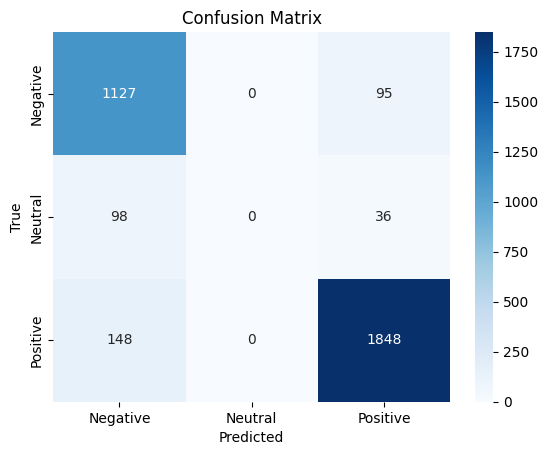

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(true_labels, preds_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Menampilkan tingkat kepercayaan untuk beberapa contoh
for i in range(10):
    print(f"Review: {val_df.iloc[i]['cleaned_review']}")
    print(f"True Label: {true_labels[i]}, Predicted Label: {preds_labels[i]}, Confidence: {preds_confidence[i]}")
    print('-'*80)

Review: app ribet banget aku pun pakai buat bayar barang dari luar negeri aja udah gitu bisa tiba² logout sendiri
True Label: 0, Predicted Label: 0, Confidence: 0.9450854659080505
--------------------------------------------------------------------------------
Review: belum bisa di upgrade data nik dan data pribadi mohon diperbaiki
True Label: 0, Predicted Label: 0, Confidence: 0.9739355444908142
--------------------------------------------------------------------------------
Review: mau transfer uanghabis update malah gk bisa dibuka
True Label: 2, Predicted Label: 0, Confidence: 0.9822291135787964
--------------------------------------------------------------------------------
Review: update terbaru tidak ada sidik jari  malah menghambat waktu login  tolong kasih fitur sidik jari lagi
True Label: 0, Predicted Label: 0, Confidence: 0.9832249879837036
--------------------------------------------------------------------------------
Review: aplikasi lawak lawak
True Label: 0, Predicted La

In [ ]:
# Mengunduh dan mengimpor stopwords bahasa Indonesia dari NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('indonesian')

# Impor library yang diperlukan
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Fungsi untuk mendapatkan kata paling sering muncul
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words=stop_words).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


Top words for Negative sentiment:
aplikasi: 2084
gak: 1230
saldo: 1127
nya: 1002
ga: 820
aja: 717
yg: 680
masuk: 662
udah: 624
pos: 620
gk: 492
apk: 491
akun: 474
tolong: 447
login: 445
pospay: 434
ya: 392
pulsa: 367
upgrade: 353
uang: 353


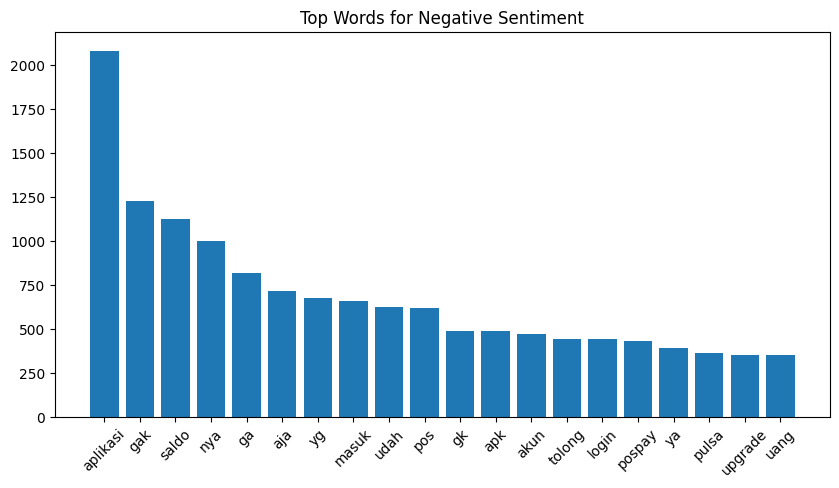

In [ ]:
# Membuat plot dan word cloud untuk sentimen negatif
sentiment_df_negative = df[df['sentiment'] == 0]
top_words_negative = get_top_n_words(sentiment_df_negative['cleaned_review'], 20)

print("\nTop words for Negative sentiment:")
for word, freq in top_words_negative:
    print(f"{word}: {freq}")

# Plot top words untuk sentimen negatif
words_neg, freqs_neg = zip(*top_words_negative)
plt.figure(figsize=(10, 5))
plt.bar(words_neg, freqs_neg)
plt.title('Top Words for Negative Sentiment')
plt.xticks(rotation=45)
plt.show()

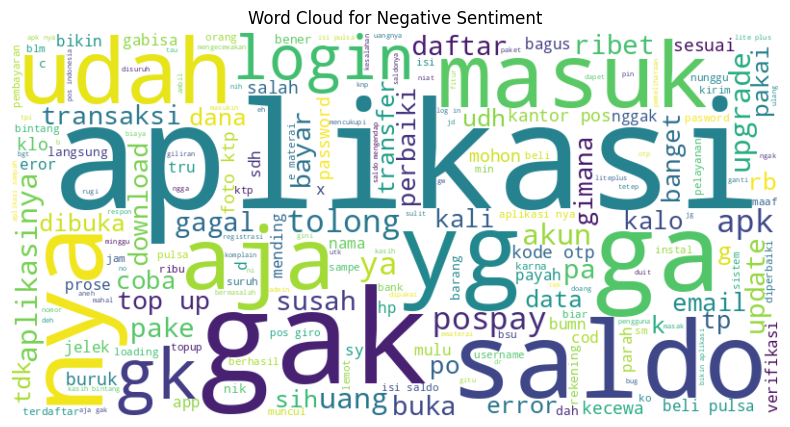

In [ ]:
# Generate and display Word Cloud untuk sentimen negatif
wordcloud_neg = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(' '.join(sentiment_df_negative['cleaned_review']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Sentiment')
plt.show()


Top words for Positive sentiment:
aplikasi: 2186
pospay: 2133
mudah: 1312
membantu: 1288
bagus: 1159
transaksi: 1146
pos: 1145
mantap: 1128
bayar: 904
pembayaran: 802
yg: 737
nya: 585
transfer: 512
memudahkan: 481
indonesia: 474
bertransaksi: 473
keren: 465
aplikasinya: 433
banget: 386
listrik: 377


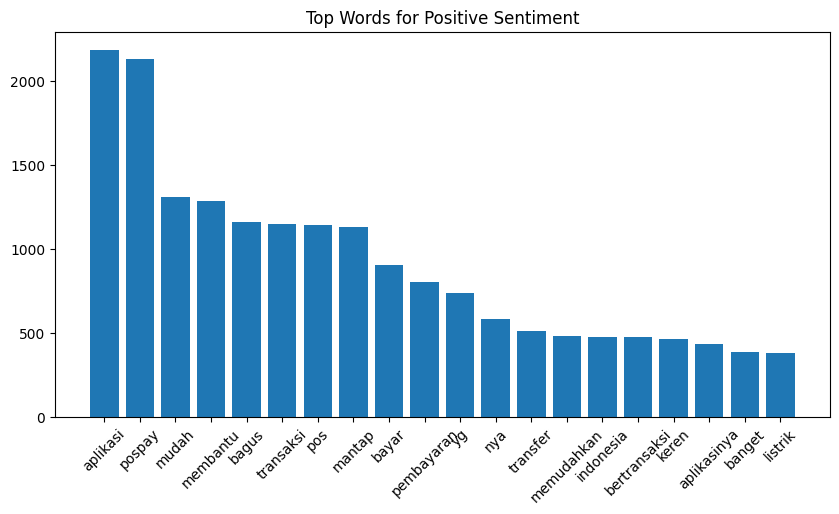

In [ ]:
# Membuat plot dan word cloud untuk sentimen positif
sentiment_df_positive = df[df['sentiment'] == 2]
top_words_positive = get_top_n_words(sentiment_df_positive['cleaned_review'], 20)

# Mencetak kata-kata teratas untuk sentimen positif
print("\nTop words for Positive sentiment:")
for word, freq in top_words_positive:
    print(f"{word}: {freq}")

# Plot top words untuk sentimen positif
words_pos, freqs_pos = zip(*top_words_positive)
plt.figure(figsize=(10, 5))
plt.bar(words_pos, freqs_pos)
plt.title('Top Words for Positive Sentiment')
plt.xticks(rotation=45)
plt.show()

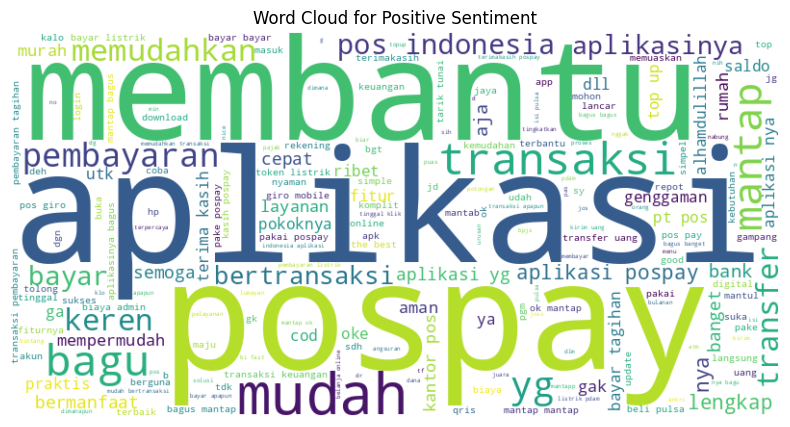

In [ ]:
# Generate and display Word Cloud untuk sentimen positif
wordcloud_pos = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(' '.join(sentiment_df_positive['cleaned_review']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment')
plt.show()